# The nonstationary fitting code is adapted from https://github.com/clairbarnes/wwa 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

import scipy
from scipy.stats import norm, gamma, lognorm, genextreme, genextreme as gev
from scipy.optimize import minimize
from xclim.indices.stats import fit

import random
import sys; sys.path.append('scripts/')
from nonstationary_fitting import *

In [2]:
era5_gmst = pd.read_csv('data/era5_global_mean_surf_temp.csv',index_col=0)
era5_gmst['gmst'] = era5_gmst['gmst'].rolling(5).mean()
era5_gmst_1979_2022 = era5_gmst[era5_gmst['time']>1978]
era5_gmst_1979_2022 = era5_gmst_1979_2022['gmst']
era5_gmst_1979_2022.index = range(1979,2023)

era5_gmst_1979_2022 = era5_gmst_1979_2022 - 273.15
era5_gmst_1979_2022 = era5_gmst_1979_2022 - era5_gmst_1979_2022[era5_gmst_1979_2022.index<2011].mean()

era5_gmst_1979_2021 = era5_gmst_1979_2022[era5_gmst_1979_2022.index<2022]
era5_gmst_1979_2021 = era5_gmst_1979_2021 - 273.15
era5_gmst_1979_2021 = era5_gmst_1979_2021 - era5_gmst_1979_2021[era5_gmst_1979_2021.index<2011].mean()

In [10]:
YRB_SAT_1979_2022 = pd.read_csv('data/YRB_averaged_SAT_1979_2022.csv',index_col=0)
YRB_SAT_1979_2022['t2m'] = YRB_SAT_1979_2022['t2m'] - 273.15
YRB_SAT_1979_2021 = YRB_SAT_1979_2022[:-1]
YRB_HWD_1979_2022 = pd.read_csv('data/YRB_averaged_HWD_1979_2022.csv',index_col=0)
YRB_HWD_1979_2021 = YRB_HWD_1979_2022[:-1]
YRB_HWL_1979_2022 = pd.read_csv('data/YRB_averaged_HWL_1979_2022.csv',index_col=0)
YRB_HWL_1979_2021 = YRB_HWL_1979_2022[:-1]
YRB_HWM_1979_2022 = pd.read_csv('data/YRB_averaged_HWM_1979_2022.csv',index_col=0)
YRB_HWM_1979_2021 = YRB_HWM_1979_2022[:-1]

In [11]:
YRB_HW_data_1979_2021 = pd.DataFrame(
    {
    'SAT':YRB_SAT_1979_2021['t2m'].tolist(),
    'HWD':YRB_HWD_1979_2021['t2m'].tolist(),
    'HWL':YRB_HWL_1979_2021['t2m'].tolist(),
    'HWM':YRB_HWM_1979_2021['t2m'].tolist(),
    'GMST':era5_gmst_1979_2021.tolist()})
YRB_HW_data_1979_2022 = pd.DataFrame(
    {
    'SAT':YRB_SAT_1979_2022['t2m'].tolist(),
    'HWD':YRB_HWD_1979_2022['t2m'].tolist(),
    'HWL':YRB_HWL_1979_2022['t2m'].tolist(),
    'HWM':YRB_HWM_1979_2022['t2m'].tolist(),
    'GMST':era5_gmst_1979_2022.tolist()})

# plot Figure 2 for SAT

## fitting type: stationary

In [79]:
x = YRB_SAT_1979_2021['t2m'].tolist()
pars = gev.fit(x)
print(pars)
neg_loglike = -gev.logpdf(x, *pars).sum()
print("AIC value:" + str(2*len(pars)+2*neg_loglike))

(0.21877450883753807, 23.15137739949357, 0.44306322049553826)
AIC value:61.11870692092705


In [83]:
x = YRB_SAT_1979_2022['t2m'].tolist()
pars = gev.fit(x)
print(pars)
neg_loglike = -gev.logpdf(x, *pars).sum()
print("AIC value:" + str(2*len(pars)+2*neg_loglike))

(0.09599736575816467, 23.14372055281912, 0.45375238697719456)
AIC value:70.35544672219207


## fitting type: shift

In [19]:
# calculate nonstationary fitting parameters
# sigma and shape are the constant parameters
# mu and alpha is two new parameters to generate the time-varing location parameter, i.e., loc = mu + alpha * covariate
params_1979_2021_mdl_SAT_shift = ns_fit(dist=gev,fittype="shift",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='SAT')
params_1979_2021_SAT_shift = params_1979_2021_mdl_SAT_shift['results']
print(params_1979_2021_SAT_shift)
print("AIC value:" + str(2*len(params_1979_2021_SAT_shift['pars'])+2*params_1979_2021_SAT_shift['fun']))

 final_simplex: (array([[23.05798513,  0.34040654,  1.23575688,  0.21566048],
       [23.05796767,  0.34040927,  1.23570215,  0.21567708],
       [23.05798057,  0.34043141,  1.23582691,  0.21574382],
       [23.05795708,  0.34044466,  1.2356929 ,  0.21569836],
       [23.05800688,  0.34042347,  1.23572999,  0.21573716]]), array([16.07126921, 16.0712693 , 16.07126934, 16.07126959, 16.07126963]))
           fun: 16.071269205456424
       message: 'Optimization terminated successfully.'
          nfev: 237
           nit: 141
          pars: {'mu': 23.057985132706797, 'sigma': 0.3404065388479822, 'alpha': 1.2357568769917124, 'shape': 0.21566047878525715}
        status: 0
       success: True
             x: array([23.05798513,  0.34040654,  1.23575688,  0.21566048])
AIC value:40.14253841091285


In [20]:
# including the 2022 event
params_1979_2022_mdl_SAT_shift = ns_fit(dist=gev,fittype="shift",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='SAT')
params_1979_2022_SAT_shift = params_1979_2022_mdl_SAT_shift['results']
print(params_1979_2022_SAT_shift)
print("AIC value:" + str(2*len(params_1979_2022_SAT_shift['pars'])+2*params_1979_2022_SAT_shift['fun']))

 final_simplex: (array([[23.05081844,  0.35450154,  1.35334223,  0.16998365],
       [23.05084818,  0.35449069,  1.35331706,  0.16995589],
       [23.05082971,  0.35450735,  1.35336115,  0.1700101 ],
       [23.05081186,  0.35449833,  1.35344014,  0.16997228],
       [23.05082233,  0.3545091 ,  1.35332034,  0.16995477]]), array([19.44466393, 19.44466396, 19.44466397, 19.44466403, 19.44466404]))
           fun: 19.44466393203229
       message: 'Optimization terminated successfully.'
          nfev: 245
           nit: 144
          pars: {'mu': 23.05081844330312, 'sigma': 0.35450153881622903, 'alpha': 1.3533422293793305, 'shape': 0.16998365257869602}
        status: 0
       success: True
             x: array([23.05081844,  0.35450154,  1.35334223,  0.16998365])
AIC value:46.88932786406458


## fitting type: scale

In [22]:
params_1979_2021_mdl_SAT_scale = ns_fit(dist=gev,fittype="scale",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='SAT')
params_1979_2021_SAT_scale = params_1979_2021_mdl_SAT_scale['results']
print(params_1979_2021_SAT_scale)
print("AIC value:" + str(2*len(params_1979_2021_SAT_scale['pars'])+2*params_1979_2021_SAT_scale['fun']))

 final_simplex: (array([[23.02750637,  0.43967335,  0.68771661,  0.39043154],
       [23.02750977,  0.43968292,  0.68774883,  0.3904584 ],
       [23.02750756,  0.43968872,  0.68767241,  0.39043021],
       [23.0275131 ,  0.43966933,  0.68764526,  0.39042382],
       [23.02752608,  0.43967013,  0.68766361,  0.39041548]]), array([25.21189118, 25.21189119, 25.21189121, 25.21189121, 25.21189121]))
           fun: 25.21189117776631
       message: 'Optimization terminated successfully.'
          nfev: 259
           nit: 157
          pars: {'mu': 23.027506367397542, 'sigma': 0.439673352790811, 'alpha': 0.6877166140868969, 'shape': 0.3904315440644089}
        status: 0
       success: True
             x: array([23.02750637,  0.43967335,  0.68771661,  0.39043154])
AIC value:58.42378235553262


In [23]:
# including the 2022 event
params_1979_2022_mdl_SAT_scale = ns_fit(dist=gev,fittype="scale",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='SAT')
params_1979_2022_SAT_scale = params_1979_2022_mdl_SAT_scale['results']
print(params_1979_2022_SAT_scale)
print("AIC value:" + str(2*len(params_1979_2022_SAT_scale['pars'])+2*params_1979_2022_SAT_scale['fun']))

 final_simplex: (array([[23.01598471,  0.47123701,  0.89520699,  0.43196819],
       [23.01599915,  0.47120484,  0.89518099,  0.43195116],
       [23.01598152,  0.4711969 ,  0.89511541,  0.4319064 ],
       [23.01597038,  0.47122669,  0.89529446,  0.43198726],
       [23.01599695,  0.47120628,  0.89515666,  0.43190413]]), array([28.16618179, 28.16618183, 28.16618184, 28.16618195, 28.16618203]))
           fun: 28.166181788719097
       message: 'Optimization terminated successfully.'
          nfev: 239
           nit: 138
          pars: {'mu': 23.015984711055683, 'sigma': 0.47123701234426196, 'alpha': 0.895206986355533, 'shape': 0.43196818960804545}
        status: 0
       success: True
             x: array([23.01598471,  0.47123701,  0.89520699,  0.43196819])
AIC value:64.3323635774382


## fitting tpye: shiftscale

In [24]:
params_1979_2021_mdl_SAT_shiftscale = ns_fit(dist=gev,fittype="shiftscale",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='SAT')
params_1979_2021_SAT_shiftscale = params_1979_2021_mdl_SAT_shiftscale['results']
print(params_1979_2021_SAT_shiftscale)
print("AIC value:" + str(2*len(params_1979_2021_SAT_shiftscale['pars'])+2*params_1979_2021_SAT_shiftscale['fun']))

 final_simplex: (array([[23.05911487,  0.33699029,  1.22900738,  0.2184255 ,  0.03160104],
       [23.05909865,  0.33695315,  1.22907324,  0.21835165,  0.0316404 ],
       [23.05910505,  0.33696519,  1.22909539,  0.2184132 ,  0.03160709],
       [23.0591213 ,  0.33695598,  1.22895487,  0.2184123 ,  0.03166558],
       [23.05907102,  0.33695977,  1.22903724,  0.21835386,  0.03159735],
       [23.05910624,  0.33694667,  1.22903619,  0.21835025,  0.03160041]]), array([16.05337427, 16.05337429, 16.0533743 , 16.05337447, 16.05337448,
       16.05337456]))
           fun: 16.053374267143056
       message: 'Optimization terminated successfully.'
          nfev: 473
           nit: 291
          pars: {'mu': 23.059114868009033, 'sigma': 0.3369902918710691, 'alpha': 1.2290073769837548, 'shape': 0.21842550051597304, 'beta': 0.03160104473318074}
        status: 0
       success: True
             x: array([23.05911487,  0.33699029,  1.22900738,  0.2184255 ,  0.03160104])
AIC value:42.10674853428

In [25]:
# including the 2022 event
params_1979_2022_mdl_SAT_shiftscale = ns_fit(dist=gev,fittype="shiftscale",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='SAT')
params_1979_2022_SAT_shiftscale = params_1979_2022_mdl_SAT_shiftscale['results']
print(params_1979_2022_SAT_shiftscale)
print("AIC value:" + str(2*len(params_1979_2022_SAT_shiftscale['pars'])+2*params_1979_2022_SAT_shiftscale['fun']))

 final_simplex: (array([[23.06062112,  0.33796579,  1.31407703,  0.19887948,  0.14796504],
       [23.0605925 ,  0.3379454 ,  1.314036  ,  0.19882562,  0.14797325],
       [23.06060546,  0.33796579,  1.31399095,  0.19886657,  0.14801012],
       [23.06061222,  0.33796657,  1.31415034,  0.19889742,  0.14799363],
       [23.0606183 ,  0.33794411,  1.3140372 ,  0.19884567,  0.14801574],
       [23.06059955,  0.33796736,  1.31408845,  0.19882846,  0.14796805]]), array([18.90042108, 18.90042112, 18.90042122, 18.90042124, 18.90042129,
       18.90042132]))
           fun: 18.900421084655704
       message: 'Optimization terminated successfully.'
          nfev: 386
           nit: 238
          pars: {'mu': 23.06062112406321, 'sigma': 0.33796579288761197, 'alpha': 1.31407703373845, 'shape': 0.19887948016665113, 'beta': 0.1479650392143052}
        status: 0
       success: True
             x: array([23.06062112,  0.33796579,  1.31407703,  0.19887948,  0.14796504])
AIC value:47.80084216931141

/Users/zeqinhuang/Documents/paper/HW_track/scripts/nonstationary_fitting.py:250: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/ep


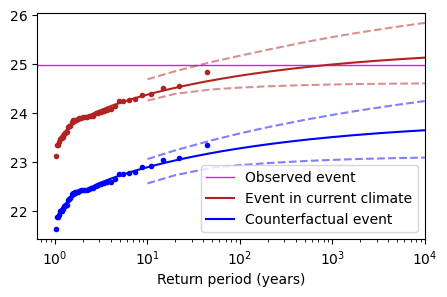

In [8]:
rlplot(params_1979_2021_mdl, era5_gmst_1979_2022.tolist()[-1], era5_gmst_1979_2022.tolist()[-1] - 1.2, YRB_SAT_1979_2022['t2m'][2022], lower = False, ax = None, ci_nsamp = 10, legend = True, seed = 1)


In [9]:
x_ci = np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rc_1 = return_ci(params_1979_2021_mdl, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)
rc_2 = return_ci(params_1979_2022_mdl, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)

/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


/Users/zeqinhuang/Documents/paper/HW_track/scripts/nonstationary_fitting.py:250: RuntimeWarning: divide by zero encountered in true_divide
  return 1/ep
/var/folders/gl/305lw9j910n_yd3gdvyjpyz80000gn/T/ipykernel_52777/687510739.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


The 2022 YRB SAT is 24.99
The return period (not include 2022 event in the fitting) of the 2022 event is 877.04
The return period (include 2022 event in the fitting) of the 2022 event is 113.24


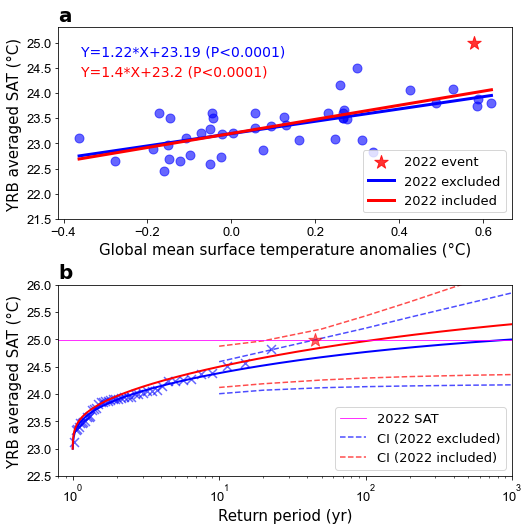

In [10]:
axes_locs = [
    [0.05,0.56,0.9,0.38],
    [0.05,0.05,0.9,0.38],
]

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_axes(axes_locs[0])
ax1.scatter(era5_gmst_1979_2021.values,YRB_SAT_1979_2021['t2m'],marker='o',color='blue',alpha=0.6,s=80)
x1 = [era5_gmst_1979_2021.min(),era5_gmst_1979_2021.max()]
mu1 = params_1979_2021['pars']['mu']
alpha1 = params_1979_2021['pars']['alpha']
alpha1, mu1 = np.polyfit(YRB_HW_data_1979_2021.GMST, YRB_HW_data_1979_2021.SAT, 1)
y1 = [mu1+x1[0]*alpha1,mu1+x1[1]*alpha1]
l1 = ax1.plot(x1,y1,c='blue',linewidth=3)
s = 'Y=' + str(round(alpha1,2)) + '*X+' + str(round(mu1,2)) + ' (P<0.0001)'
ax1.text(x = 0.05, y = 0.85, s = s, fontsize=14, color = 'b',transform=ax1.transAxes)

star = ax1.scatter(era5_gmst_1979_2022.values[-1],YRB_SAT_1979_2022['t2m'][2022],marker='*',color='red',alpha=0.8,s=200)
x2 = [era5_gmst_1979_2022.min(),era5_gmst_1979_2022.max()]
mu2 = params_1979_2022['pars']['mu']
alpha2 = params_1979_2022['pars']['alpha']
alpha2, mu2 = np.polyfit(YRB_HW_data_1979_2022.GMST, YRB_HW_data_1979_2022.SAT, 1)
y2 = [mu2+x2[0]*alpha2,mu2+x2[1]*alpha2]
l2 = ax1.plot(x2,y2,c='red',linewidth=3)
s = 'Y=' + str(round(alpha2,2)) + '*X+' + str(round(mu2,2)) + ' (P<0.0001)'
ax1.text(x = 0.05, y = 0.75, s = s, fontsize=14, color = 'r',transform=ax1.transAxes)

ax1.set_ylabel('YRB averaged SAT (°C)',fontdict={'fontsize':15})
ax1.set_xlabel('Global mean surface temperature anomalies (°C)',fontdict={'fontsize':15})
ax1.set_ylim([21.5,25.3])
ax1.legend(
    [star,l1[0],l2[0]], ['2022 event','2022 excluded','2022 included'],fancybox = True,frameon=True, loc='lower right', #bbox_to_anchor=[0.65,0.35], 
    ncol=1,fontsize=13)

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

############# ax2
ax2 = fig.add_axes(axes_locs[1])
# z for return period
z1 = []
for i in range(len(YRB_SAT_1979_2022['t2m'].tolist())):
    z1.append(return_period(mdl = params_1979_2021_mdl,event_value = YRB_SAT_1979_2022['t2m'].tolist()[i],covariate=era5_gmst_1979_2022.tolist()[-1]))
z2 = []
for i in range(len(YRB_SAT_1979_2022['t2m'].tolist())):
    z2.append(return_period(mdl = params_1979_2022_mdl,event_value = YRB_SAT_1979_2022['t2m'].tolist()[i],covariate=era5_gmst_1979_2022.tolist()[-1]))

y_fit_1 = np.linspace(23, 25.1, 1000)
x_fit_1 = return_period(mdl = params_1979_2021_mdl,event_value = y_fit_1,covariate=era5_gmst_1979_2022.tolist()[-1])
ax2.plot(x_fit_1,y_fit_1,'-',color='blue',linewidth=2)

y_fit_2 = np.linspace(23, 26, 1000)
x_fit_2 = return_period(mdl = params_1979_2022_mdl,event_value = y_fit_2,covariate=era5_gmst_1979_2022.tolist()[-1])
ax2.plot(x_fit_2,y_fit_2,'-',color='red',linewidth=2)

l1 = ax2.plot(x_ci, rc_1.transpose(), color = "blue", ls = "--", alpha = 0.7)
l2 = ax2.plot(x_ci, rc_2.transpose(), color = "red", ls = "--", alpha = 0.7)

# ax2.scatter(z1,YRB_SAT_1979_2022['t2m'],marker='x',color='blue',alpha=0.6,s=80)
# ax2.scatter(z2,YRB_SAT_1979_2022['t2m'],marker='+',color='red',alpha=0.6,s=120)

YRB_SAT_1979_2022_shifted_to_2022 = YRB_SAT_1979_2022['t2m'] + (era5_gmst_1979_2022[2022] - era5_gmst_1979_2022) * alpha1
empirical_x = 1 / (1 - np.arange(1,len(YRB_SAT_1979_2022_shifted_to_2022)+1)/float(len(YRB_SAT_1979_2022_shifted_to_2022) + 1))
ax2.scatter(empirical_x[:-1],YRB_SAT_1979_2022_shifted_to_2022.sort_values()[:-1],marker='x',color='blue',alpha=0.6,s=80)
ax2.scatter(empirical_x[-1],YRB_SAT_1979_2022_shifted_to_2022.sort_values()[2022],marker='*',color='red',alpha=0.6,s=200,zorder=10)
# empirical_x = 1 / (1 - np.arange(1,len(YRB_SAT_1979_2022['t2m'])+1)/float(len(YRB_SAT_1979_2022['t2m']) + 1))
# ax2.scatter(empirical_x,YRB_SAT_1979_2022['t2m'].sort_values(),marker='x',color='blue',alpha=0.6,s=80)

ax2.set_xscale('log')
ax2.set_ylabel('YRB averaged SAT (°C)',fontdict={'fontsize':15})
ax2.set_xlabel('Return period (yr)',fontdict={'fontsize':15})
ax2.set_ylim([22.5,26])
ax2.set_xlim([0.8,10**3])
l3 = ax2.axhline(y=YRB_SAT_1979_2022_shifted_to_2022.sort_values()[2022],color='magenta',linewidth=0.8)

for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='left')
add_panel_label(ax1, 'a', x=0, y = 1.11)
add_panel_label(ax2, 'b', x=0, y = 1.11)

ax2.legend(
    [l3,l1[0],l2[0]], ['2022 SAT','CI (2022 excluded)','CI (2022 included)'],fancybox = True,frameon=True, loc='lower right',
    ncol=1,fontsize=13)

rp_2022_1 = return_period(mdl = params_1979_2021_mdl,event_value = YRB_SAT_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
rp_2022_2 = return_period(mdl = params_1979_2022_mdl,event_value = YRB_SAT_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
print('The 2022 YRB SAT is {:.2f}'.format(YRB_SAT_1979_2022['t2m'][2022]))
print('The return period (not include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_1))
print('The return period (include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_2))

plt.tight_layout()
plt.savefig("Figures/Fig2_GEV_fitting.pdf",bbox_inches='tight')
fig.savefig('Figures/Fig2_GEV_fitting.png',bbox_inches='tight')

# plot Figure S2 for HWD

## fitting type: stationary

In [80]:
x = YRB_HWD_1979_2021['t2m'].tolist()
pars = gev.fit(x)
print(pars)
neg_loglike = -gev.logpdf(x, *pars).sum()
print("AIC value:" + str(2*len(pars)+2*neg_loglike))

(-0.06999494283626981, 8.386236201236471, 4.094973809883337)
AIC value:266.8622549664996


In [84]:
x = YRB_HWD_1979_2022['t2m'].tolist()
pars = gev.fit(x)
print(pars)
neg_loglike = -gev.logpdf(x, *pars).sum()
print("AIC value:" + str(2*len(pars)+2*neg_loglike))

(-0.19118264219689318, 8.339841118226971, 4.202668526831746)
AIC value:280.91484157405375


## fitting type: shift

In [27]:
# calculate nonstationary fitting parameters
# sigma and shape are the constant parameters
# mu and alpha is two new parameters to generate the time-varing location parameter, i.e., loc = mu + alpha * covariate
params_1979_2021_mdl_HWD_shift = ns_fit(dist=gev,fittype="shift",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='HWD')
params_1979_2021_HWD_shift = params_1979_2021_mdl_HWD_shift['results']
print(params_1979_2021_HWD_shift)
print("AIC value:" + str(2*len(params_1979_2021_HWD_shift['pars'])+2*params_1979_2021_HWD_shift['fun']))

 final_simplex: (array([[ 7.84656638,  3.2010728 , 14.49398373,  0.07247644],
       [ 7.84655712,  3.20107189, 14.4940683 ,  0.07247634],
       [ 7.84656108,  3.20107114, 14.49402177,  0.07247855],
       [ 7.84654452,  3.20105755, 14.49401915,  0.07247446],
       [ 7.8465708 ,  3.20106061, 14.49403154,  0.07247653]]), array([115.93016633, 115.93016633, 115.93016633, 115.93016633,
       115.93016633]))
           fun: 115.93016633027659
       message: 'Optimization terminated successfully.'
          nfev: 288
           nit: 162
          pars: {'mu': 7.846566381065604, 'sigma': 3.201072795592532, 'alpha': 14.493983734879135, 'shape': 0.0724764427472755}
        status: 0
       success: True
             x: array([ 7.84656638,  3.2010728 , 14.49398373,  0.07247644])
AIC value:239.86033266055318


In [28]:
# including the 2022 event
params_1979_2022_mdl_HWD_shift = ns_fit(dist=gev,fittype="shift",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='HWD')
params_1979_2022_HWD_shift = params_1979_2022_mdl_HWD_shift['results']
print(params_1979_2022_HWD_shift)
print("AIC value:" + str(2*len(params_1979_2022_HWD_shift['pars'])+2*params_1979_2022_HWD_shift['fun']))

 final_simplex: (array([[ 7.84695447,  3.38986129, 14.46298954, -0.03531049],
       [ 7.84696837,  3.38985929, 14.46294028, -0.03530994],
       [ 7.84696017,  3.38985615, 14.46304184, -0.0353086 ],
       [ 7.84697099,  3.38986723, 14.46295002, -0.03530741],
       [ 7.84694754,  3.38984539, 14.46297245, -0.03531079]]), array([123.75553, 123.75553, 123.75553, 123.75553, 123.75553]))
           fun: 123.75552999767783
       message: 'Optimization terminated successfully.'
          nfev: 341
           nit: 201
          pars: {'mu': 7.846954468543578, 'sigma': 3.3898612875256986, 'alpha': 14.462989544715889, 'shape': -0.03531049033411009}
        status: 0
       success: True
             x: array([ 7.84695447,  3.38986129, 14.46298954, -0.03531049])
AIC value:255.51105999535565


## fitting type: scale

In [29]:
params_1979_2021_mdl_HWD_scale = ns_fit(dist=gev,fittype="scale",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='HWD')
params_1979_2021_HWD_scale = params_1979_2021_mdl_HWD_scale['results']
print(params_1979_2021_HWD_scale)
print("AIC value:" + str(2*len(params_1979_2021_HWD_scale['pars'])+2*params_1979_2021_HWD_scale['fun']))

 final_simplex: (array([[7.18561378, 4.16308667, 5.92169392, 0.20071849],
       [7.18564738, 4.16310444, 5.92163705, 0.20072137],
       [7.18561668, 4.16308205, 5.92162358, 0.20071382],
       [7.18562031, 4.16309931, 5.92168307, 0.20071705],
       [7.1856601 , 4.16308878, 5.92165186, 0.2007173 ]]), array([128.08339458, 128.08339458, 128.08339458, 128.08339458,
       128.08339458]))
           fun: 128.08339457742932
       message: 'Optimization terminated successfully.'
          nfev: 301
           nit: 175
          pars: {'mu': 7.185613776500993, 'sigma': 4.163086673135728, 'alpha': 5.921693923483028, 'shape': 0.20071848882275606}
        status: 0
       success: True
             x: array([7.18561378, 4.16308667, 5.92169392, 0.20071849])
AIC value:264.16678915485863


In [30]:
# including the 2022 event
params_1979_2022_mdl_HWD_scale = ns_fit(dist=gev,fittype="scale",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='HWD')
params_1979_2022_HWD_scale = params_1979_2022_mdl_HWD_scale['results']
print(params_1979_2022_HWD_scale)
print("AIC value:" + str(2*len(params_1979_2022_HWD_scale['pars'])+2*params_1979_2022_HWD_scale['fun']))

 final_simplex: (array([[7.04465434, 4.20475706, 6.16403931, 0.10923274],
       [7.04467433, 4.20474281, 6.16396456, 0.10922879],
       [7.04466322, 4.20475232, 6.16401615, 0.10922958],
       [7.04467969, 4.20475444, 6.16397473, 0.10923005],
       [7.04468578, 4.20475859, 6.164008  , 0.1092319 ]]), array([135.20140172, 135.20140172, 135.20140172, 135.20140172,
       135.20140172]))
           fun: 135.2014017157979
       message: 'Optimization terminated successfully.'
          nfev: 350
           nit: 203
          pars: {'mu': 7.044654341592692, 'sigma': 4.204757057209117, 'alpha': 6.164039313597268, 'shape': 0.10923274239183313}
        status: 0
       success: True
             x: array([7.04465434, 4.20475706, 6.16403931, 0.10923274])
AIC value:278.4028034315958


## fitting type: shiftscale

In [31]:
params_1979_2021_mdl_HWD_shiftscale = ns_fit(dist=gev,fittype="shiftscale",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='HWD')
params_1979_2021_HWD_shiftscale = params_1979_2021_mdl_HWD_shiftscale['results']
print(params_1979_2021_HWD_shiftscale)
print("AIC value:" + str(2*len(params_1979_2021_HWD_shiftscale['pars'])+2*params_1979_2021_HWD_shiftscale['fun']))

 final_simplex: (array([[ 7.86718186,  2.74951327, 13.54242034,  0.03909603,  3.14612376],
       [ 7.8672061 ,  2.74951189, 13.5423827 ,  0.03909503,  3.14622289],
       [ 7.86719045,  2.74949516, 13.54237083,  0.03909183,  3.14621142],
       [ 7.86718029,  2.74951042, 13.54243463,  0.03909646,  3.14619381],
       [ 7.86718992,  2.74949183, 13.54245166,  0.03909134,  3.14613971],
       [ 7.86722366,  2.7495119 , 13.5424414 ,  0.03909876,  3.14608609]]), array([114.22011154, 114.22011154, 114.22011154, 114.22011154,
       114.22011154, 114.22011154]))
           fun: 114.22011153785392
       message: 'Optimization terminated successfully.'
          nfev: 751
           nit: 469
          pars: {'mu': 7.8671818647485505, 'sigma': 2.7495132652913385, 'alpha': 13.542420336816956, 'shape': 0.03909603395199366, 'beta': 3.1461237556278854}
        status: 0
       success: True
             x: array([ 7.86718186,  2.74951327, 13.54242034,  0.03909603,  3.14612376])
AIC value:238.44022

In [32]:
# including the 2022 event
params_1979_2022_mdl_HWD_shiftscale = ns_fit(dist=gev,fittype="shiftscale",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='HWD')
params_1979_2022_HWD_shiftscale = params_1979_2022_mdl_HWD_shiftscale['results']
print(params_1979_2022_HWD_shiftscale)
print("AIC value:" + str(2*len(params_1979_2022_HWD_shiftscale['pars'])+2*params_1979_2022_HWD_shiftscale['fun']))

 final_simplex: (array([[ 7.8902419 ,  2.79942087, 13.86265657, -0.02114448,  4.11486536],
       [ 7.89024478,  2.79942583, 13.86258455, -0.02114258,  4.11483715],
       [ 7.89022862,  2.79942563, 13.86257504, -0.02114249,  4.11489334],
       [ 7.89023739,  2.7994316 , 13.86266386, -0.02114036,  4.11483688],
       [ 7.89024625,  2.79943035, 13.86269411, -0.02114082,  4.11490249],
       [ 7.89024087,  2.79943681, 13.86270269, -0.02114785,  4.1148951 ]]), array([120.26190108, 120.26190108, 120.26190108, 120.26190108,
       120.26190108, 120.26190108]))
           fun: 120.26190108325262
       message: 'Optimization terminated successfully.'
          nfev: 638
           nit: 396
          pars: {'mu': 7.89024190440286, 'sigma': 2.7994208682906945, 'alpha': 13.862656574278018, 'shape': -0.02114447972691503, 'beta': 4.114865364017096}
        status: 0
       success: True
             x: array([ 7.8902419 ,  2.79942087, 13.86265657, -0.02114448,  4.11486536])
AIC value:250.5238021

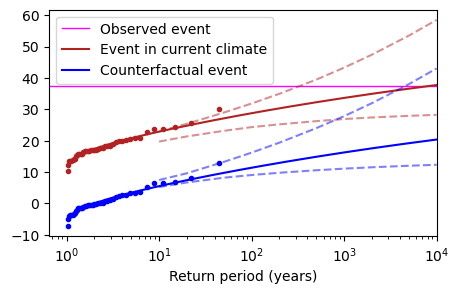

In [14]:
rlplot(params_1979_2021_mdl, era5_gmst_1979_2022.tolist()[-1], era5_gmst_1979_2022.tolist()[-1] - 1.2, YRB_HWD_1979_2022['t2m'][2022], lower = False, ax = None, ci_nsamp = 10, legend = True, seed = 1)

In [15]:
x_ci = np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rc_1 = return_ci(params_1979_2021_mdl, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)
rc_2 = return_ci(params_1979_2022_mdl, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)

/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


The 2022 YRB HWD is 37.38
The return period (not include 2022 event in the fitting) of the 2022 event is 8003.27
The return period (include 2022 event in the fitting) of the 2022 event is 282.22


/var/folders/gl/305lw9j910n_yd3gdvyjpyz80000gn/T/ipykernel_52777/725902344.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


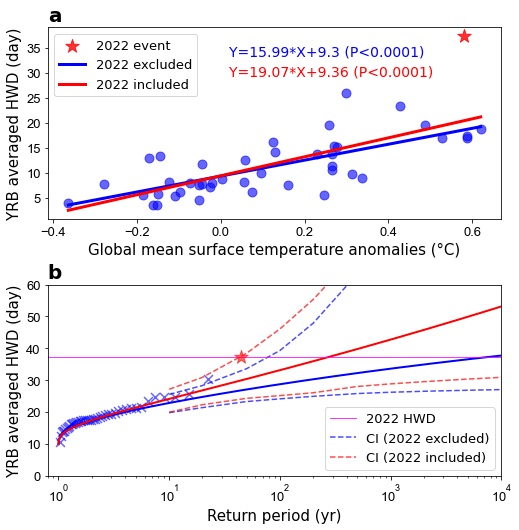

In [16]:
axes_locs = [
    [0.05,0.56,0.9,0.38],
    [0.05,0.05,0.9,0.38],
]

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_axes(axes_locs[0])
ax1.scatter(era5_gmst_1979_2021.values,YRB_HWD_1979_2021['t2m'],marker='o',color='blue',alpha=0.6,s=80)
x1 = [era5_gmst_1979_2021.min(),era5_gmst_1979_2021.max()]
mu1 = params_1979_2021['pars']['mu']
alpha1 = params_1979_2021['pars']['alpha']
alpha1, mu1 = np.polyfit(YRB_HW_data_1979_2021.GMST, YRB_HW_data_1979_2021.HWD, 1)
y1 = [mu1+x1[0]*alpha1,mu1+x1[1]*alpha1]
l1 = ax1.plot(x1,y1,c='blue',linewidth=3)
s = 'Y=' + str(round(alpha1,2)) + '*X+' + str(round(mu1,2)) + ' (P<0.0001)'
ax1.text(x = 0.4, y = 0.85, s = s, fontsize=14, color = 'b',transform=ax1.transAxes)

star = ax1.scatter(era5_gmst_1979_2022.values[-1],YRB_HWD_1979_2022['t2m'][2022],marker='*',color='red',alpha=0.8,s=200)
x2 = [era5_gmst_1979_2022.min(),era5_gmst_1979_2022.max()]
mu2 = params_1979_2022['pars']['mu']
alpha2 = params_1979_2022['pars']['alpha']
alpha2, mu2 = np.polyfit(YRB_HW_data_1979_2022.GMST, YRB_HW_data_1979_2022.HWD, 1)
y2 = [mu2+x2[0]*alpha2,mu2+x2[1]*alpha2]
l2 = ax1.plot(x2,y2,c='red',linewidth=3)
s = 'Y=' + str(round(alpha2,2)) + '*X+' + str(round(mu2,2)) + ' (P<0.0001)'
ax1.text(x = 0.4, y = 0.75, s = s, fontsize=14, color = 'r',transform=ax1.transAxes)

ax1.set_ylabel('YRB averaged HWD (day)',fontdict={'fontsize':15})
ax1.set_xlabel('Global mean surface temperature anomalies (°C)',fontdict={'fontsize':15})
# ax1.set_ylim([21.5,25.3])
ax1.legend(
    [star,l1[0],l2[0]], ['2022 event','2022 excluded','2022 included'],fancybox = True,frameon=True, loc='upper left', #bbox_to_anchor=[0.65,0.35], 
    ncol=1,fontsize=13)

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

############# ax2
ax2 = fig.add_axes(axes_locs[1])
# z for return period
z1 = []
for i in range(len(YRB_HWD_1979_2022['t2m'].tolist())):
    z1.append(return_period(mdl = params_1979_2021_mdl,event_value = YRB_HWD_1979_2022['t2m'].tolist()[i],covariate=era5_gmst_1979_2022.tolist()[-1]))
z2 = []
for i in range(len(YRB_HWD_1979_2022['t2m'].tolist())):
    z2.append(return_period(mdl = params_1979_2022_mdl,event_value = YRB_HWD_1979_2022['t2m'].tolist()[i],covariate=era5_gmst_1979_2022.tolist()[-1]))

y_fit_1 = np.linspace(10, 60, 1000)
x_fit_1 = return_period(mdl = params_1979_2021_mdl,event_value = y_fit_1,covariate=era5_gmst_1979_2022.tolist()[-1])
ax2.plot(x_fit_1,y_fit_1,'-',color='blue',linewidth=2)

y_fit_2 = np.linspace(10, 60, 1000)
x_fit_2 = return_period(mdl = params_1979_2022_mdl,event_value = y_fit_2,covariate=era5_gmst_1979_2022.tolist()[-1])
ax2.plot(x_fit_2,y_fit_2,'-',color='red',linewidth=2)

l1 = ax2.plot(x_ci, rc_1.transpose(), color = "blue", ls = "--", alpha = 0.7)
l2 = ax2.plot(x_ci, rc_2.transpose(), color = "red", ls = "--", alpha = 0.7)

YRB_HWD_1979_2022_shifted_to_2022 = YRB_HWD_1979_2022['t2m'] + (era5_gmst_1979_2022[2022] - era5_gmst_1979_2022) * alpha1
empirical_x = 1 / (1 - np.arange(1,len(YRB_HWD_1979_2022_shifted_to_2022)+1)/float(len(YRB_HWD_1979_2022_shifted_to_2022) + 1))
ax2.scatter(empirical_x[:-1],YRB_HWD_1979_2022_shifted_to_2022.sort_values()[:-1],marker='x',color='blue',alpha=0.6,s=80)
ax2.scatter(empirical_x[-1],YRB_HWD_1979_2022_shifted_to_2022.sort_values()[2022],marker='*',color='red',alpha=0.6,s=200,zorder=10)

ax2.set_xscale('log')
ax2.set_ylabel('YRB averaged HWD (day)',fontdict={'fontsize':15})
ax2.set_xlabel('Return period (yr)',fontdict={'fontsize':15})
ax2.set_ylim([0,60])
ax2.set_xlim([0.8,10**4])
l3 = ax2.axhline(y=YRB_HWD_1979_2022_shifted_to_2022.sort_values()[2022],color='magenta',linewidth=0.8)

for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='left')
add_panel_label(ax1, 'a', x=0, y = 1.11)
add_panel_label(ax2, 'b', x=0, y = 1.11)

ax2.legend(
    [l3,l1[0],l2[0]], ['2022 HWD','CI (2022 excluded)','CI (2022 included)'],fancybox = True,frameon=True, loc='lower right',
    ncol=1,fontsize=13)

rp_2022_1 = return_period(mdl = params_1979_2021_mdl,event_value = YRB_HWD_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
rp_2022_2 = return_period(mdl = params_1979_2022_mdl,event_value = YRB_HWD_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
print('The 2022 YRB HWD is {:.2f}'.format(YRB_HWD_1979_2022['t2m'][2022]))
print('The return period (not include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_1))
print('The return period (include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_2))

plt.tight_layout()
plt.savefig("Figures/FigS2_GEV_fitting_for_HWD.pdf",bbox_inches='tight')
fig.savefig('Figures/FigS2_GEV_fitting_for_HWD.png',bbox_inches='tight')

# plot Figure S3 for HWL

## fitting type: stationary

In [81]:
x = YRB_HWL_1979_2021['t2m'].tolist()
pars = gev.fit(x)
print(pars)
neg_loglike = -gev.logpdf(x, *pars).sum()
print("AIC value:" + str(2*len(pars)+2*neg_loglike))

(-0.026983435214398936, 3.3321281581961815, 1.3200238826979676)
AIC value:166.93615409099365


In [85]:
x = YRB_HWL_1979_2022['t2m'].tolist()
pars = gev.fit(x)
print(pars)
neg_loglike = -gev.logpdf(x, *pars).sum()
print("AIC value:" + str(2*len(pars)+2*neg_loglike))

(-0.15992193473618155, 3.3171393124141115, 1.3826225450568481)
AIC value:181.25940497154534


## fitting type: shift

In [69]:
# calculate nonstationary fitting parameters
# sigma and shape are the constant parameters
# mu and alpha is two new parameters to generate the time-varing location parameter, i.e., loc = mu + alpha * covariate
params_1979_2021_mdl_HWL_shift = ns_fit(dist=gev,fittype="shift",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='HWL')
params_1979_2021_HWL_shift = params_1979_2021_mdl_HWL_shift['results']
print(params_1979_2021_HWL_shift)
print("AIC value:" + str(2*len(params_1979_2021_HWL_shift['pars'])+2*params_1979_2021_HWL_shift['fun']))

 final_simplex: (array([[ 3.08420146,  0.95268812,  4.1399999 , -0.04354328],
       [ 3.08420685,  0.95267128,  4.13992732, -0.04355414],
       [ 3.08419028,  0.95267872,  4.14006538, -0.04353984],
       [ 3.08421648,  0.95268542,  4.14000419, -0.04353812],
       [ 3.08421069,  0.95267235,  4.13991095, -0.04354001]]), array([66.78125879, 66.7812588 , 66.7812588 , 66.7812588 , 66.7812588 ]))
           fun: 66.78125879079093
       message: 'Optimization terminated successfully.'
          nfev: 297
           nit: 179
          pars: {'mu': 3.0842014600982157, 'sigma': 0.9526881202774333, 'alpha': 4.139999902124957, 'shape': -0.043543277830914995}
        status: 0
       success: True
             x: array([ 3.08420146,  0.95268812,  4.1399999 , -0.04354328])
AIC value:141.56251758158186


In [70]:
# including the 2022 event
params_1979_2022_mdl_HWL_shift = ns_fit(dist=gev,fittype="shift",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='HWL')
params_1979_2022_HWL_shift = params_1979_2022_mdl_HWL_shift['results']
print(params_1979_2022_HWL_shift)
print("AIC value:" + str(2*len(params_1979_2022_HWL_shift['pars'])+2*params_1979_2022_HWL_shift['fun']))

 final_simplex: (array([[ 3.0832649 ,  1.01786623,  4.16471463, -0.15854143],
       [ 3.08323951,  1.01789294,  4.16479356, -0.15854101],
       [ 3.08325484,  1.01787508,  4.16467046, -0.15855262],
       [ 3.08328124,  1.017893  ,  4.16472464, -0.15853886],
       [ 3.08325735,  1.01788095,  4.16472858, -0.15855196]]), array([74.11601171, 74.11601172, 74.11601172, 74.11601173, 74.11601174]))
           fun: 74.11601171211255
       message: 'Optimization terminated successfully.'
          nfev: 280
           nit: 161
          pars: {'mu': 3.083264896264389, 'sigma': 1.0178662310416546, 'alpha': 4.164714625327454, 'shape': -0.15854142826007583}
        status: 0
       success: True
             x: array([ 3.0832649 ,  1.01786623,  4.16471463, -0.15854143])
AIC value:156.2320234242251


## fitting type: scale

In [46]:
params_1979_2021_mdl_HWL_scale = ns_fit(dist=gev,fittype="scale",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='HWL')
params_1979_2021_HWL_scale = params_1979_2021_mdl_HWL_scale['results']
print(params_1979_2021_HWL_scale)
print("AIC value:" + str(2*len(params_1979_2021_HWL_scale['pars'])+2*params_1979_2021_HWL_scale['fun']))

 final_simplex: (array([[2.94926711, 1.28918948, 1.78869279, 0.1594269 ],
       [2.94927707, 1.28918495, 1.78872303, 0.15943393],
       [2.94925745, 1.28917837, 1.78871173, 0.15942172],
       [2.94930832, 1.28918736, 1.78860303, 0.15942227],
       [2.94926554, 1.28917874, 1.78864596, 0.15942891]]), array([78.80961925, 78.80961925, 78.80961925, 78.80961925, 78.80961925]))
           fun: 78.80961924838125
       message: 'Optimization terminated successfully.'
          nfev: 275
           nit: 165
          pars: {'mu': 2.949267109948781, 'sigma': 1.2891894845481302, 'alpha': 1.7886927890999293, 'shape': 0.15942689886407907}
        status: 0
       success: True
             x: array([2.94926711, 1.28918948, 1.78869279, 0.1594269 ])
AIC value:165.6192384967625


In [37]:
# including the 2022 event
params_1979_2022_mdl_HWL_scale = ns_fit(dist=gev,fittype="scale",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='HWL')
params_1979_2022_HWL_scale = params_1979_2022_mdl_HWL_scale['results']
print(params_1979_2022_HWL_scale)
print("AIC value:" + str(2*len(params_1979_2022_HWL_scale['pars'])+2*params_1979_2022_HWL_scale['fun']))

 final_simplex: (array([[2.8922071 , 1.31337116, 1.89945516, 0.04293243],
       [2.89222638, 1.31336855, 1.89938004, 0.04292429],
       [2.89224265, 1.31338738, 1.89938406, 0.04292678],
       [2.8922258 , 1.31338533, 1.89942334, 0.04292429],
       [2.8922175 , 1.31337388, 1.89937094, 0.04292779]]), array([85.94168979, 85.94168979, 85.94168979, 85.94168979, 85.9416898 ]))
           fun: 85.94168979069666
       message: 'Optimization terminated successfully.'
          nfev: 285
           nit: 166
          pars: {'mu': 2.892207103686096, 'sigma': 1.313371156558031, 'alpha': 1.8994551616800048, 'shape': 0.04293242857596674}
        status: 0
       success: True
             x: array([2.8922071 , 1.31337116, 1.89945516, 0.04293243])
AIC value:179.8833795813933


## fitting type: shiftscale

In [149]:
params_1979_2021_mdl_HWL_shiftscale = ns_fit(dist=gev,fittype="shiftscale",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='HWL',solver='Powell')
params_1979_2021_HWL_shiftscale = params_1979_2021_mdl_HWL_shiftscale['results']
print(params_1979_2021_HWL_shiftscale)
print("AIC value:" + str(2*len(params_1979_2021_HWL_shiftscale['pars'])+2*params_1979_2021_HWL_shiftscale['fun']))

   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [-0.05156823, -0.12471287, -0.01874349, -0.02118287,  0.27688872]])
     fun: 66.43008377483498
 message: 'Optimization terminated successfully.'
    nfev: 244
     nit: 4
    pars: {'mu': 3.0850747204044846, 'sigma': 0.907774748542336, 'alpha': 4.197291840578779, 'shape': -0.026266524189742135, 'beta': 0.4512780944150625}
  status: 0
 success: True
       x: array([ 3.08507472,  0.90777475,  4.19729184, -0.02626652,  0.45127809])
AIC value:142.86016754966997


/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2322: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2323: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [151]:
# including the 2022 event
params_1979_2022_mdl_HWL_shiftscale = ns_fit(dist=gev,fittype="shiftscale",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='HWL',solver='TNC')
params_1979_2022_HWL_shiftscale = params_1979_2022_mdl_HWL_shiftscale['results']
print(params_1979_2022_HWL_shiftscale)
print("AIC value:" + str(2*len(params_1979_2022_HWL_shiftscale['pars'])+2*params_1979_2022_HWL_shiftscale['fun']))

     fun: 77.42795899571354
     jac: array([-0.22175755, 12.95110516,  0.13335892, -1.98365768,  0.93173896])
 message: 'Linear search failed'
    nfev: 432
     nit: 1
    pars: {'mu': 3.301005420515073, 'sigma': 1.3875672929450493, 'alpha': 4.737508613597873, 'shape': -0.15826187144342713, 'beta': 1.5987469513062842}
  status: 4
 success: False
       x: array([ 3.30100542,  1.38756729,  4.73750861, -0.15826187,  1.59874695])
AIC value:164.85591799142708


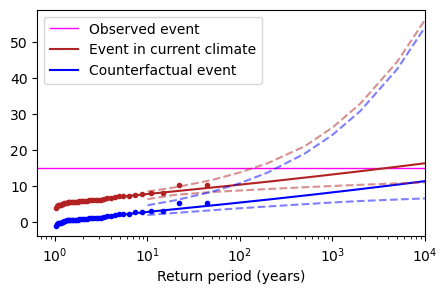

In [61]:
rlplot(params_1979_2021_mdl_HWL_shift, era5_gmst_1979_2022.tolist()[-1], era5_gmst_1979_2022.tolist()[-1] - 1.2, YRB_HWL_1979_2022['t2m'][2022], lower = False, ax = None, ci_nsamp = 10, legend = True, seed = 1)

In [73]:
x_ci = np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rc_1 = return_ci(params_1979_2021_mdl_HWL_shift, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)
rc_2 = return_ci(params_1979_2022_mdl_HWL_shift, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)

The 2022 YRB HWL is 14.96
The return period (not include 2022 event in the fitting) of the 2022 event is 3892.25
The return period (include 2022 event in the fitting) of the 2022 event is 303.78


/var/folders/gl/305lw9j910n_yd3gdvyjpyz80000gn/T/ipykernel_79357/3501213962.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


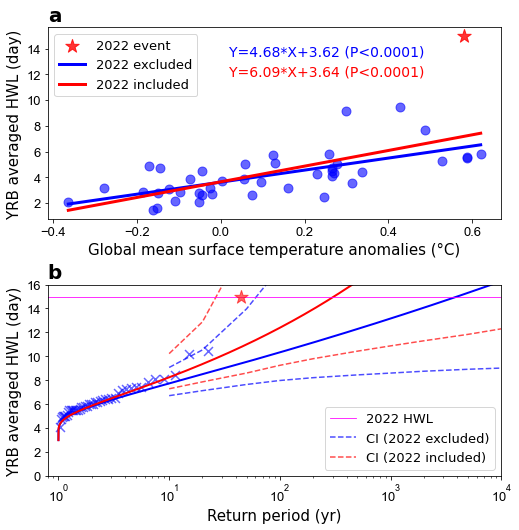

In [74]:
axes_locs = [
    [0.05,0.56,0.9,0.38],
    [0.05,0.05,0.9,0.38],
]

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_axes(axes_locs[0])
ax1.scatter(era5_gmst_1979_2021.values,YRB_HWL_1979_2021['t2m'],marker='o',color='blue',alpha=0.6,s=80)
x1 = [era5_gmst_1979_2021.min(),era5_gmst_1979_2021.max()]
mu1 = params_1979_2021_HWL_shift['pars']['mu']
alpha1 = params_1979_2021_HWL_shift['pars']['alpha']
alpha1, mu1 = np.polyfit(YRB_HW_data_1979_2021.GMST, YRB_HW_data_1979_2021.HWL, 1)
y1 = [mu1+x1[0]*alpha1,mu1+x1[1]*alpha1]
l1 = ax1.plot(x1,y1,c='blue',linewidth=3)
s = 'Y=' + str(round(alpha1,2)) + '*X+' + str(round(mu1,2)) + ' (P<0.0001)'
ax1.text(x = 0.4, y = 0.85, s = s, fontsize=14, color = 'b',transform=ax1.transAxes)

star = ax1.scatter(era5_gmst_1979_2022.values[-1],YRB_HWL_1979_2022['t2m'][2022],marker='*',color='red',alpha=0.8,s=200)
x2 = [era5_gmst_1979_2022.min(),era5_gmst_1979_2022.max()]
mu2 = params_1979_2022_HWL_shift['pars']['mu']
alpha2 = params_1979_2022_HWL_shift['pars']['alpha']
alpha2, mu2 = np.polyfit(YRB_HW_data_1979_2022.GMST, YRB_HW_data_1979_2022.HWL, 1)
y2 = [mu2+x2[0]*alpha2,mu2+x2[1]*alpha2]
l2 = ax1.plot(x2,y2,c='red',linewidth=3)
s = 'Y=' + str(round(alpha2,2)) + '*X+' + str(round(mu2,2)) + ' (P<0.0001)'
ax1.text(x = 0.4, y = 0.75, s = s, fontsize=14, color = 'r',transform=ax1.transAxes)

ax1.set_ylabel('YRB averaged HWL (day)',fontdict={'fontsize':15})
ax1.set_xlabel('Global mean surface temperature anomalies (°C)',fontdict={'fontsize':15})
# ax1.set_ylim([21.5,25.3])
ax1.legend(
    [star,l1[0],l2[0]], ['2022 event','2022 excluded','2022 included'],fancybox = True,frameon=True, loc='upper left', #bbox_to_anchor=[0.65,0.35], 
    ncol=1,fontsize=13)

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

############# ax2
ax2 = fig.add_axes(axes_locs[1])
# z for return period
z1 = []
for i in range(len(YRB_HWL_1979_2022['t2m'].tolist())):
    z1.append(return_period(mdl = params_1979_2021_mdl_HWL_shift,event_value = YRB_HWL_1979_2022['t2m'].tolist()[i],covariate=era5_gmst_1979_2022.tolist()[-1]))
z2 = []
for i in range(len(YRB_HWL_1979_2022['t2m'].tolist())):
    z2.append(return_period(mdl = params_1979_2022_mdl_HWL_shift,event_value = YRB_HWL_1979_2022['t2m'].tolist()[i],covariate=era5_gmst_1979_2022.tolist()[-1]))

y_fit_1 = np.linspace(3, 16, 1000)
x_fit_1 = return_period(mdl = params_1979_2021_mdl_HWL_shift,event_value = y_fit_1,covariate=era5_gmst_1979_2022.tolist()[-1])
ax2.plot(x_fit_1,y_fit_1,'-',color='blue',linewidth=2)

y_fit_2 = np.linspace(3, 16, 1000)
x_fit_2 = return_period(mdl = params_1979_2022_mdl_HWL_shift,event_value = y_fit_2,covariate=era5_gmst_1979_2022.tolist()[-1])
ax2.plot(x_fit_2,y_fit_2,'-',color='red',linewidth=2)

l1 = ax2.plot(x_ci, rc_1.transpose(), color = "blue", ls = "--", alpha = 0.7)
l2 = ax2.plot(x_ci, rc_2.transpose(), color = "red", ls = "--", alpha = 0.7)

YRB_HWL_1979_2022_shifted_to_2022 = YRB_HWL_1979_2022['t2m'] + (era5_gmst_1979_2022[2022] - era5_gmst_1979_2022) * alpha1
empirical_x = 1 / (1 - np.arange(1,len(YRB_HWL_1979_2022_shifted_to_2022)+1)/float(len(YRB_HWL_1979_2022_shifted_to_2022) + 1))
ax2.scatter(empirical_x[:-1],YRB_HWL_1979_2022_shifted_to_2022.sort_values()[:-1],marker='x',color='blue',alpha=0.6,s=80)
ax2.scatter(empirical_x[-1],YRB_HWL_1979_2022_shifted_to_2022.sort_values()[2022],marker='*',color='red',alpha=0.6,s=200,zorder=10)

ax2.set_xscale('log')
ax2.set_ylabel('YRB averaged HWL (day)',fontdict={'fontsize':15})
ax2.set_xlabel('Return period (yr)',fontdict={'fontsize':15})
ax2.set_ylim([0,16])
ax2.set_xlim([0.8,10**4])
l3 = ax2.axhline(y=YRB_HWL_1979_2022_shifted_to_2022.sort_values()[2022],color='magenta',linewidth=0.8)

for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='left')
add_panel_label(ax1, 'a', x=0, y = 1.11)
add_panel_label(ax2, 'b', x=0, y = 1.11)

ax2.legend(
    [l3,l1[0],l2[0]], ['2022 HWL','CI (2022 excluded)','CI (2022 included)'],fancybox = True,frameon=True, loc='lower right',
    ncol=1,fontsize=13)

rp_2022_1 = return_period(mdl = params_1979_2021_mdl_HWL_shift,event_value = YRB_HWL_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
rp_2022_2 = return_period(mdl = params_1979_2022_mdl_HWL_shift,event_value = YRB_HWL_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
print('The 2022 YRB HWL is {:.2f}'.format(YRB_HWL_1979_2022['t2m'][2022]))
print('The return period (not include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_1))
print('The return period (include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_2))

plt.tight_layout()
plt.savefig("Figures/FigS2_GEV_fitting_for_HWL.pdf",bbox_inches='tight')
fig.savefig('Figures/FigS2_GEV_fitting_for_HWL.png',bbox_inches='tight')

# plot Figure S4 for HWM

## fitting type: stationary

In [82]:
x = YRB_HWM_1979_2021['t2m'].tolist()
pars = gev.fit(x)
print(pars)
neg_loglike = -gev.logpdf(x, *pars).sum()
print("AIC value:" + str(2*len(pars)+2*neg_loglike))

(0.19941235719792383, 0.6497721741412517, 0.12963272015052096)
AIC value:-43.53005530764301


In [86]:
x = YRB_HWM_1979_2022['t2m'].tolist()
pars = gev.fit(x)
print(pars)
neg_loglike = -gev.logpdf(x, *pars).sum()
print("AIC value:" + str(2*len(pars)+2*neg_loglike))

(-0.020860886592828566, 0.642201661100125, 0.1329372476638357)
AIC value:-32.26659433082783


## fitting type: shift

In [53]:
# calculate nonstationary fitting parameters
# sigma and shape are the constant parameters
# mu and alpha is two new parameters to generate the time-varing location parameter, i.e., loc = mu + alpha * covariate
params_1979_2021_mdl_HWM_shift = ns_fit(dist=gev,fittype="shift",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='HWM')
params_1979_2021_HWM_shift = params_1979_2021_mdl_HWM_shift['results']
print(params_1979_2021_HWM_shift)
print("AIC value:" + str(2*len(params_1979_2021_HWM_shift['pars'])+2*params_1979_2021_HWM_shift['fun']))

 final_simplex: (array([[0.62137156, 0.10186382, 0.31663369, 0.13333933],
       [0.6213849 , 0.10186644, 0.31662556, 0.13340555],
       [0.62137988, 0.1018593 , 0.31661511, 0.13334173],
       [0.62138081, 0.10185938, 0.31664373, 0.13340258],
       [0.62137834, 0.10186507, 0.31667354, 0.13335661]]), array([-33.49173881, -33.49173875, -33.49173874, -33.49173867,
       -33.49173854]))
           fun: -33.491738808909204
       message: 'Optimization terminated successfully.'
          nfev: 194
           nit: 107
          pars: {'mu': 0.6213715622946966, 'sigma': 0.10186381628657958, 'alpha': 0.3166336889325252, 'shape': 0.13333932905892798}
        status: 0
       success: True
             x: array([0.62137156, 0.10186382, 0.31663369, 0.13333933])
AIC value:-58.98347761781841


In [54]:
# including the 2022 event
params_1979_2022_mdl_HWM_shift = ns_fit(dist=gev,fittype="shift",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='HWM')
params_1979_2022_HWM_shift = params_1979_2022_mdl_HWM_shift['results']
print(params_1979_2022_HWM_shift)
print("AIC value:" + str(2*len(params_1979_2022_HWM_shift['pars'])+2*params_1979_2022_HWM_shift['fun']))

 final_simplex: (array([[ 0.61561346,  0.10456986,  0.33078518, -0.05041803],
       [ 0.61561356,  0.10457444,  0.33080474, -0.05048188],
       [ 0.61560838,  0.10456432,  0.33076625, -0.05050376],
       [ 0.61560824,  0.10457913,  0.33077752, -0.05043949],
       [ 0.61562444,  0.10457532,  0.3307284 , -0.05045334]]), array([-28.81151187, -28.81151187, -28.81151176, -28.81151151,
       -28.81151149]))
           fun: -28.81151186814016
       message: 'Optimization terminated successfully.'
          nfev: 250
           nit: 147
          pars: {'mu': 0.6156134617274125, 'sigma': 0.10456986030601433, 'alpha': 0.3307851841586313, 'shape': -0.0504180302027316}
        status: 0
       success: True
             x: array([ 0.61561346,  0.10456986,  0.33078518, -0.05041803])
AIC value:-49.62302373628032


## fitting type: scale

In [55]:
params_1979_2021_mdl_HWM_scale = ns_fit(dist=gev,fittype="scale",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='HWM')
params_1979_2021_HWM_scale = params_1979_2021_mdl_HWM_scale['results']
print(params_1979_2021_HWM_scale)
print("AIC value:" + str(2*len(params_1979_2021_HWM_scale['pars'])+2*params_1979_2021_HWM_scale['fun']))

 final_simplex: (array([[0.63798151, 0.12883024, 0.06474936, 0.27232981],
       [0.63797127, 0.1288336 , 0.06479996, 0.27237393],
       [0.63798575, 0.12882221, 0.06474835, 0.27225072],
       [0.63796273, 0.12882806, 0.06476279, 0.27227965],
       [0.63797116, 0.12882347, 0.06479123, 0.27239814]]), array([-25.21362364, -25.21362355, -25.2136235 , -25.2136234 ,
       -25.21362327]))
           fun: -25.2136236421086
       message: 'Optimization terminated successfully.'
          nfev: 176
           nit: 102
          pars: {'mu': 0.6379815081361615, 'sigma': 0.12883024356548867, 'alpha': 0.06474935838862916, 'shape': 0.2723298101004379}
        status: 0
       success: True
             x: array([0.63798151, 0.12883024, 0.06474936, 0.27232981])
AIC value:-42.4272472842172


In [56]:
# including the 2022 event
params_1979_2022_mdl_HWM_scale = ns_fit(dist=gev,fittype="scale",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='HWM')
params_1979_2022_HWM_scale = params_1979_2022_mdl_HWM_scale['results']
print(params_1979_2022_HWM_scale)
print("AIC value:" + str(2*len(params_1979_2022_HWM_scale['pars'])+2*params_1979_2022_HWM_scale['fun']))

 final_simplex: (array([[0.62692269, 0.13046945, 0.07716139, 0.07318026],
       [0.62693338, 0.13048073, 0.0771601 , 0.07325271],
       [0.6269518 , 0.130477  , 0.07710461, 0.07319041],
       [0.62694283, 0.13048072, 0.07706192, 0.07310991],
       [0.62692018, 0.13047339, 0.0771251 , 0.07321877]]), array([-19.56356365, -19.56356343, -19.56356333, -19.56356291,
       -19.56356286]))
           fun: -19.56356364629155
       message: 'Optimization terminated successfully.'
          nfev: 194
           nit: 113
          pars: {'mu': 0.6269226882274863, 'sigma': 0.13046945276535427, 'alpha': 0.07716138576902197, 'shape': 0.0731802612586951}
        status: 0
       success: True
             x: array([0.62692269, 0.13046945, 0.07716139, 0.07318026])
AIC value:-31.127127292583097


## fitting type: shiftscale

In [57]:
params_1979_2021_mdl_HWM_shiftscale = ns_fit(dist=gev,fittype="shiftscale",data=YRB_HW_data_1979_2021,cov_name='GMST',var_name='HWM')
params_1979_2021_HWM_shiftscale = params_1979_2021_mdl_HWM_shiftscale['results']
print(params_1979_2021_HWM_shiftscale)
print("AIC value:" + str(2*len(params_1979_2021_HWM_shiftscale['pars'])+2*params_1979_2021_HWM_shiftscale['fun']))

 final_simplex: (array([[ 0.62144995,  0.10230319,  0.31635437,  0.13419058, -0.00361897],
       [ 0.62145664,  0.10229914,  0.31642035,  0.1342874 , -0.00357247],
       [ 0.62144976,  0.10229353,  0.31636057,  0.13410754, -0.00357049],
       [ 0.62146015,  0.10231031,  0.31638273,  0.13419037, -0.00361062],
       [ 0.62143793,  0.1023004 ,  0.3163754 ,  0.13409722, -0.00362102],
       [ 0.62144779,  0.10230989,  0.31635653,  0.13427897, -0.00358069]]), array([-33.49424729, -33.49424718, -33.49424715, -33.49424699,
       -33.49424688, -33.49424678]))
           fun: -33.49424729445716
       message: 'Optimization terminated successfully.'
          nfev: 322
           nit: 206
          pars: {'mu': 0.6214499545143253, 'sigma': 0.1023031884331665, 'alpha': 0.3163543749576293, 'shape': 0.13419058462907893, 'beta': -0.003618965721047618}
        status: 0
       success: True
             x: array([ 0.62144995,  0.10230319,  0.31635437,  0.13419058, -0.00361897])
AIC value:-56.98

In [58]:
# including the 2022 event
params_1979_2022_mdl_HWM_shiftscale = ns_fit(dist=gev,fittype="shiftscale",data=YRB_HW_data_1979_2022,cov_name='GMST',var_name='HWM')
params_1979_2022_HWM_shiftscale = params_1979_2022_mdl_HWM_shiftscale['results']
print(params_1979_2022_HWM_shiftscale)
print("AIC value:" + str(2*len(params_1979_2022_HWM_shiftscale['pars'])+2*params_1979_2022_HWM_shiftscale['fun']))

 final_simplex: (array([[ 0.61569318,  0.09918067,  0.35139086, -0.00819175,  0.05926865],
       [ 0.61569739,  0.0991847 ,  0.35135431, -0.00819767,  0.05926447],
       [ 0.61569691,  0.09917731,  0.35135486, -0.00822972,  0.05924697],
       [ 0.61569043,  0.09918154,  0.35136099, -0.00824821,  0.05922393],
       [ 0.61569989,  0.09918319,  0.35137681, -0.00815115,  0.05924093],
       [ 0.61569784,  0.09917798,  0.35137351, -0.00826203,  0.05924838]]), array([-29.41744127, -29.41744119, -29.41744119, -29.41744118,
       -29.41744116, -29.41744105]))
           fun: -29.417441265937207
       message: 'Optimization terminated successfully.'
          nfev: 419
           nit: 262
          pars: {'mu': 0.6156931845914541, 'sigma': 0.09918067219950892, 'alpha': 0.3513908575444817, 'shape': -0.00819174997528376, 'beta': 0.05926864718914414}
        status: 0
       success: True
             x: array([ 0.61569318,  0.09918067,  0.35139086, -0.00819175,  0.05926865])
AIC value:-48.8

/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/zeqinhuang/Documents/paper/HW_track/scripts/nonstationary_fitting.py:250: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/ep


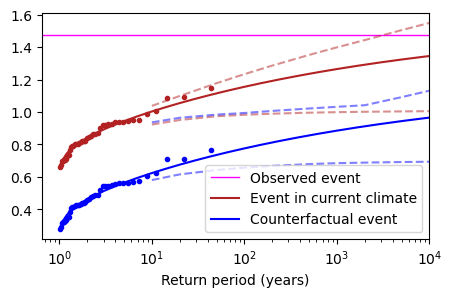

In [62]:
rlplot(params_1979_2021_mdl_HWM_shift, era5_gmst_1979_2022.tolist()[-1], era5_gmst_1979_2022.tolist()[-1] - 1.2, YRB_HWM_1979_2022['t2m'][2022], lower = False, ax = None, ci_nsamp = 10, legend = True, seed = 1)

In [102]:
sorted([2,3,43,12,45],reverse=lower)

[2, 3, 12, 43, 45]

In [75]:
x_ci = np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rc_1 = return_ci(params_1979_2021_mdl_HWM_shift, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)
rc_2 = return_ci(params_1979_2022_mdl_HWM_shift, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)

/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


/Users/zeqinhuang/Documents/paper/HW_track/scripts/nonstationary_fitting.py:250: RuntimeWarning: divide by zero encountered in true_divide
  return 1/ep
/var/folders/gl/305lw9j910n_yd3gdvyjpyz80000gn/T/ipykernel_79357/443961628.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


The 2022 YRB HWM is 1.48
The return period (not include 2022 event in the fitting) of the 2022 event is 7022377.73
The return period (include 2022 event in the fitting) of the 2022 event is 254.87


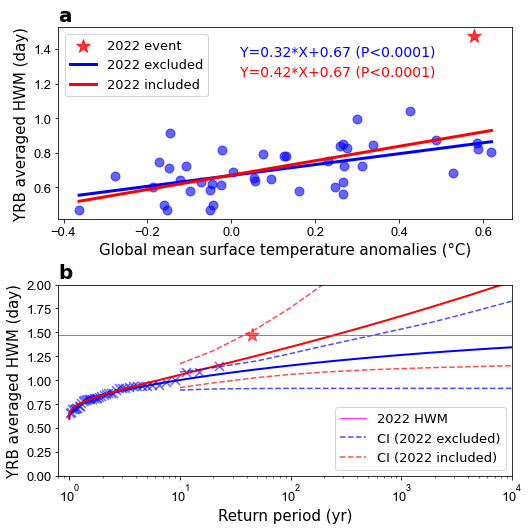

In [103]:
axes_locs = [
    [0.05,0.56,0.9,0.38],
    [0.05,0.05,0.9,0.38],
]

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_axes(axes_locs[0])
ax1.scatter(era5_gmst_1979_2021.values,YRB_HWM_1979_2021['t2m'],marker='o',color='blue',alpha=0.6,s=80)
x1 = [era5_gmst_1979_2021.min(),era5_gmst_1979_2021.max()]
mu1 = params_1979_2021_HWM_shift['pars']['mu']
alpha1 = params_1979_2021_HWM_shift['pars']['alpha']
alpha1, mu1 = np.polyfit(YRB_HW_data_1979_2021.GMST, YRB_HW_data_1979_2021.HWM, 1)
y1 = [mu1+x1[0]*alpha1,mu1+x1[1]*alpha1]
l1 = ax1.plot(x1,y1,c='blue',linewidth=3)
s = 'Y=' + str(round(alpha1,2)) + '*X+' + str(round(mu1,2)) + ' (P<0.0001)'
ax1.text(x = 0.4, y = 0.85, s = s, fontsize=14, color = 'b',transform=ax1.transAxes)

star = ax1.scatter(era5_gmst_1979_2022.values[-1],YRB_HWM_1979_2022['t2m'][2022],marker='*',color='red',alpha=0.8,s=200)
x2 = [era5_gmst_1979_2022.min(),era5_gmst_1979_2022.max()]
mu2 = params_1979_2022_HWM_shift['pars']['mu']
alpha2 = params_1979_2022_HWM_shift['pars']['alpha']
alpha2, mu2 = np.polyfit(YRB_HW_data_1979_2022.GMST, YRB_HW_data_1979_2022.HWM, 1)
y2 = [mu2+x2[0]*alpha2,mu2+x2[1]*alpha2]
l2 = ax1.plot(x2,y2,c='red',linewidth=3)
s = 'Y=' + str(round(alpha2,2)) + '*X+' + str(round(mu2,2)) + ' (P<0.0001)'
ax1.text(x = 0.4, y = 0.75, s = s, fontsize=14, color = 'r',transform=ax1.transAxes)

ax1.set_ylabel('YRB averaged HWM (day)',fontdict={'fontsize':15})
ax1.set_xlabel('Global mean surface temperature anomalies (°C)',fontdict={'fontsize':15})
# ax1.set_ylim([21.5,25.3])
ax1.legend(
    [star,l1[0],l2[0]], ['2022 event','2022 excluded','2022 included'],fancybox = True,frameon=True, loc='upper left', #bbox_to_anchor=[0.65,0.35], 
    ncol=1,fontsize=13)

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

############# ax2
ax2 = fig.add_axes(axes_locs[1])
# z for return period
z1 = []
for i in range(len(YRB_HWM_1979_2022['t2m'].tolist())):
    z1.append(return_period(mdl = params_1979_2021_mdl_HWM_shift,event_value = YRB_HWM_1979_2022['t2m'].tolist()[i],covariate=era5_gmst_1979_2022.tolist()[-1]))
z2 = []
for i in range(len(YRB_HWM_1979_2022['t2m'].tolist())):
    z2.append(return_period(mdl = params_1979_2022_mdl_HWM_shift,event_value = YRB_HWM_1979_2022['t2m'].tolist()[i],covariate=era5_gmst_1979_2022.tolist()[-1]))

y_fit_1 = np.linspace(0.6, 2, 1000)
x_fit_1 = return_period(mdl = params_1979_2021_mdl_HWM_shift,event_value = y_fit_1,covariate=era5_gmst_1979_2022.tolist()[-1])
ax2.plot(x_fit_1,y_fit_1,'-',color='blue',linewidth=2)

y_fit_2 = np.linspace(0.6, 2, 1000)
x_fit_2 = return_period(mdl = params_1979_2022_mdl_HWM_shift,event_value = y_fit_2,covariate=era5_gmst_1979_2022.tolist()[-1])
ax2.plot(x_fit_2,y_fit_2,'-',color='red',linewidth=2)

l1 = ax2.plot(x_ci, rc_1.transpose(), color = "blue", ls = "--", alpha = 0.7)
l2 = ax2.plot(x_ci, rc_2.transpose(), color = "red", ls = "--", alpha = 0.7)

YRB_HWM_1979_2022_shifted_to_2022 = YRB_HWM_1979_2022['t2m'] + (era5_gmst_1979_2022[2022] - era5_gmst_1979_2022) * alpha1
empirical_x = 1 / (1 - np.arange(1,len(YRB_HWM_1979_2022_shifted_to_2022)+1)/float(len(YRB_HWM_1979_2022_shifted_to_2022) + 1))
ax2.scatter(empirical_x[:-1],YRB_HWM_1979_2022_shifted_to_2022.sort_values()[:-1],marker='x',color='blue',alpha=0.6,s=80)
ax2.scatter(empirical_x[-1],YRB_HWM_1979_2022_shifted_to_2022.sort_values()[2022],marker='*',color='red',alpha=0.6,s=200,zorder=10)

ax2.set_xscale('log')
ax2.set_ylabel('YRB averaged HWM (day)',fontdict={'fontsize':15})
ax2.set_xlabel('Return period (yr)',fontdict={'fontsize':15})
ax2.set_ylim([0,2])
ax2.set_xlim([0.8,10**4])
l3 = ax2.axhline(y=YRB_HWM_1979_2022_shifted_to_2022.sort_values()[2022],color='magenta',linewidth=0.8)

for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='left')
add_panel_label(ax1, 'a', x=0, y = 1.11)
add_panel_label(ax2, 'b', x=0, y = 1.11)

ax2.legend(
    [l3,l1[0],l2[0]], ['2022 HWM','CI (2022 excluded)','CI (2022 included)'],fancybox = True,frameon=True, loc='lower right',
    ncol=1,fontsize=13)

rp_2022_1 = return_period(mdl = params_1979_2021_mdl_HWM_shift,event_value = YRB_HWM_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
rp_2022_2 = return_period(mdl = params_1979_2022_mdl_HWM_shift,event_value = YRB_HWM_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
print('The 2022 YRB HWM is {:.2f}'.format(YRB_HWM_1979_2022['t2m'][2022]))
print('The return period (not include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_1))
print('The return period (include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_2))

plt.tight_layout()
plt.savefig("Figures/FigS2_GEV_fitting_for_HWM.pdf",bbox_inches='tight')
fig.savefig('Figures/FigS2_GEV_fitting_for_HWM.png',bbox_inches='tight')

# plot Figure S5

/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1945: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1945: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1945: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1945: RuntimeWarning: invalid value encountered in true

The 2022 YRB HWD is 37.38
The return period (not include 2022 event in the fitting) of the 2022 event is 189.72
The return period (include 2022 event in the fitting) of the 2022 event is 53.49
The 2022 YRB HWL is 14.96
The return period (not include 2022 event in the fitting) of the 2022 event is 3892.25
The return period (include 2022 event in the fitting) of the 2022 event is 303.78


/Users/zeqinhuang/Documents/paper/HW_track/scripts/nonstationary_fitting.py:250: RuntimeWarning: divide by zero encountered in true_divide
  return 1/ep
/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/zeqinhuang/miniforge3/envs/tfMac38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2500: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


The 2022 YRB HWM is 1.48
The return period (not include 2022 event in the fitting) of the 2022 event is 7022377.73
The return period (include 2022 event in the fitting) of the 2022 event is 254.87


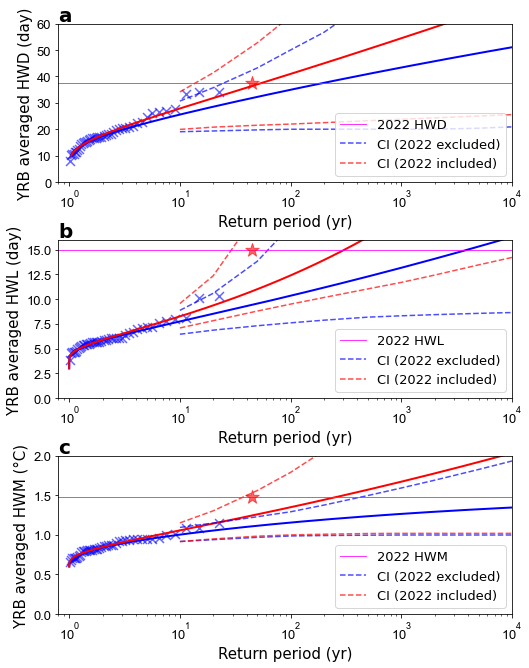

In [136]:
axes_locs = [
    [0.05,0.65,0.9,0.22],
    [0.05,0.35,0.9,0.22],
    [0.05,0.05,0.9,0.22],
]
############# ax1
fig = plt.figure(figsize = (7,10))
ax1 = fig.add_axes(axes_locs[0])

y_fit_1 = np.linspace(10, 60, 1000)
x_fit_1 = return_period(mdl = params_1979_2021_mdl_HWD_shiftscale,event_value = y_fit_1,covariate=era5_gmst_1979_2022.tolist()[-1])
ax1.plot(x_fit_1,y_fit_1,'-',color='blue',linewidth=2)

y_fit_2 = np.linspace(10, 60, 1000)
x_fit_2 = return_period(mdl = params_1979_2022_mdl_HWD_shiftscale,event_value = y_fit_2,covariate=era5_gmst_1979_2022.tolist()[-1])
ax1.plot(x_fit_2,y_fit_2,'-',color='red',linewidth=2)

x_ci = np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rc_1 = return_ci(params_1979_2021_mdl_HWD_shiftscale, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)
rc_2 = return_ci(params_1979_2022_mdl_HWD_shiftscale, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)
l1 = ax1.plot(x_ci, rc_1.transpose(), color = "blue", ls = "--", alpha = 0.7)
l2 = ax1.plot(x_ci, rc_2.transpose(), color = "red", ls = "--", alpha = 0.7)

YRB_HWD_1979_2022_shifted_to_2022 = stransf(mdl=params_1979_2022_mdl_HWD_shiftscale,covariate=era5_gmst_1979_2022.tolist()[-1],lower=False)
empirical_x = 1 / (1 - np.arange(1,len(YRB_HWD_1979_2022_shifted_to_2022)+1)/float(len(YRB_HWD_1979_2022_shifted_to_2022) + 1))
ax1.scatter(empirical_x[:-1],np.sort(YRB_HWD_1979_2022_shifted_to_2022[:-1]),marker='x',color='blue',alpha=0.6,s=80)
ax1.scatter(empirical_x[-1],YRB_HWD_1979_2022_shifted_to_2022[-1],marker='*',color='red',alpha=0.6,s=200,zorder=10)

ax1.set_xscale('log')
ax1.set_ylabel('YRB averaged HWD (day)',fontdict={'fontsize':15})
ax1.set_xlabel('Return period (yr)',fontdict={'fontsize':15})
ax1.set_ylim([0,60])
ax1.set_xlim([0.8,10**4])
l3 = ax1.axhline(y=YRB_HWD_1979_2022_shifted_to_2022[-1],color='magenta',linewidth=0.8)

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

add_panel_label(ax1, 'a', x=0, y = 1.11)

ax1.legend(
    [l3,l1[0],l2[0]], ['2022 HWD','CI (2022 excluded)','CI (2022 included)'],fancybox = True,frameon=True, loc='lower right',
    ncol=1,fontsize=13)

rp_2022_1 = return_period(mdl = params_1979_2021_mdl_HWD_shiftscale,event_value = YRB_HWD_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
rp_2022_2 = return_period(mdl = params_1979_2022_mdl_HWD_shiftscale,event_value = YRB_HWD_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
print('The 2022 YRB HWD is {:.2f}'.format(YRB_HWD_1979_2022['t2m'][2022]))
print('The return period (not include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_1))
print('The return period (include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_2))

############# ax2
ax2 = fig.add_axes(axes_locs[1])

y_fit_1 = np.linspace(3, 16, 1000)
x_fit_1 = return_period(mdl = params_1979_2021_mdl_HWL_shift,event_value = y_fit_1,covariate=era5_gmst_1979_2022.tolist()[-1])
ax2.plot(x_fit_1,y_fit_1,'-',color='blue',linewidth=2)

y_fit_2 = np.linspace(3, 16, 1000)
x_fit_2 = return_period(mdl = params_1979_2022_mdl_HWL_shift,event_value = y_fit_2,covariate=era5_gmst_1979_2022.tolist()[-1])
ax2.plot(x_fit_2,y_fit_2,'-',color='red',linewidth=2)

x_ci = np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rc_1 = return_ci(params_1979_2021_mdl_HWL_shift, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)
rc_2 = return_ci(params_1979_2022_mdl_HWL_shift, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)
l1 = ax2.plot(x_ci, rc_1.transpose(), color = "blue", ls = "--", alpha = 0.7)
l2 = ax2.plot(x_ci, rc_2.transpose(), color = "red", ls = "--", alpha = 0.7)

YRB_HWL_1979_2022_shifted_to_2022 = stransf(mdl=params_1979_2022_mdl_HWL_shift,covariate=era5_gmst_1979_2022.tolist()[-1],lower=False)
empirical_x = 1 / (1 - np.arange(1,len(YRB_HWL_1979_2022_shifted_to_2022)+1)/float(len(YRB_HWL_1979_2022_shifted_to_2022) + 1))
ax2.scatter(empirical_x[:-1],np.sort(YRB_HWL_1979_2022_shifted_to_2022[:-1]),marker='x',color='blue',alpha=0.6,s=80)
ax2.scatter(empirical_x[-1],YRB_HWL_1979_2022_shifted_to_2022[-1],marker='*',color='red',alpha=0.6,s=200,zorder=10)

ax2.set_xscale('log')
ax2.set_ylabel('YRB averaged HWL (day)',fontdict={'fontsize':15})
ax2.set_xlabel('Return period (yr)',fontdict={'fontsize':15})
ax2.set_ylim([0,16])
ax2.set_xlim([0.8,10**4])
l3 = ax2.axhline(y=YRB_HWL_1979_2022_shifted_to_2022[-1],color='magenta',linewidth=0.8)

for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

add_panel_label(ax2, 'b', x=0, y = 1.11)

ax2.legend(
    [l3,l1[0],l2[0]], ['2022 HWL','CI (2022 excluded)','CI (2022 included)'],fancybox = True,frameon=True, loc='lower right',
    ncol=1,fontsize=13)

rp_2022_1 = return_period(mdl = params_1979_2021_mdl_HWL_shift,event_value = YRB_HWL_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
rp_2022_2 = return_period(mdl = params_1979_2022_mdl_HWL_shift,event_value = YRB_HWL_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
print('The 2022 YRB HWL is {:.2f}'.format(YRB_HWL_1979_2022['t2m'][2022]))
print('The return period (not include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_1))
print('The return period (include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_2))

############# ax3
ax3 = fig.add_axes(axes_locs[2])

y_fit_1 = np.linspace(0.6, 2, 1000)
x_fit_1 = return_period(mdl = params_1979_2021_mdl_HWM_shift,event_value = y_fit_1,covariate=era5_gmst_1979_2022.tolist()[-1])
ax3.plot(x_fit_1,y_fit_1,'-',color='blue',linewidth=2)

y_fit_2 = np.linspace(0.6, 2, 1000)
x_fit_2 = return_period(mdl = params_1979_2022_mdl_HWM_shift,event_value = y_fit_2,covariate=era5_gmst_1979_2022.tolist()[-1])
ax3.plot(x_fit_2,y_fit_2,'-',color='red',linewidth=2)

x_ci = np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rc_1 = return_ci(params_1979_2021_mdl_HWM_shift, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)
rc_2 = return_ci(params_1979_2022_mdl_HWM_shift, era5_gmst_1979_2022.tolist()[-1], lower = False, ci_nsamp = 100, seed = 1)
l1 = ax3.plot(x_ci, rc_1.transpose(), color = "blue", ls = "--", alpha = 0.7)
l2 = ax3.plot(x_ci, rc_2.transpose(), color = "red", ls = "--", alpha = 0.7)

YRB_HWM_1979_2022_shifted_to_2022 = stransf(mdl=params_1979_2022_mdl_HWM_shift,covariate=era5_gmst_1979_2022.tolist()[-1],lower=False)
empirical_x = 1 / (1 - np.arange(1,len(YRB_HWM_1979_2022_shifted_to_2022)+1)/float(len(YRB_HWM_1979_2022_shifted_to_2022) + 1))
ax3.scatter(empirical_x[:-1],np.sort(YRB_HWM_1979_2022_shifted_to_2022[:-1]),marker='x',color='blue',alpha=0.6,s=80)
ax3.scatter(empirical_x[-1],YRB_HWM_1979_2022_shifted_to_2022[-1],marker='*',color='red',alpha=0.6,s=200,zorder=10)

ax3.set_xscale('log')
ax3.set_ylabel('YRB averaged HWM (°C)',fontdict={'fontsize':15})
ax3.set_xlabel('Return period (yr)',fontdict={'fontsize':15})
ax3.set_ylim([0,2])
ax3.set_xlim([0.8,10**4])
l3 = ax3.axhline(y=YRB_HWM_1979_2022_shifted_to_2022[-1],color='magenta',linewidth=0.8)

for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(13)

add_panel_label(ax3, 'c', x=0, y = 1.11)

ax3.legend(
    [l3,l1[0],l2[0]], ['2022 HWM','CI (2022 excluded)','CI (2022 included)'],fancybox = True,frameon=True, loc='lower right',
    ncol=1,fontsize=13)

rp_2022_1 = return_period(mdl = params_1979_2021_mdl_HWM_shift,event_value = YRB_HWM_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
rp_2022_2 = return_period(mdl = params_1979_2022_mdl_HWM_shift,event_value = YRB_HWM_1979_2022['t2m'][2022],covariate=era5_gmst_1979_2022.tolist()[-1])
print('The 2022 YRB HWM is {:.2f}'.format(YRB_HWM_1979_2022['t2m'][2022]))
print('The return period (not include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_1))
print('The return period (include 2022 event in the fitting) of the 2022 event is {:.2f}'.format(rp_2022_2))

plt.show()
# plt.tight_layout()
fig.savefig("Figures/FigS5_GEV_fitting_for_HW_charas.pdf",bbox_inches='tight')
fig.savefig('Figures/FigS5_GEV_fitting_for_HW_charas.png',bbox_inches='tight')